# Predicting Age from Resting-State fMRI

In this project, we work on resting-state fMRI data to investigate brain connectivity patterns.
 

In [9]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets, maskers, plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure


# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [10]:

# Lets fetch the data!
data = datasets.fetch_development_fmri()

In [11]:

# Get the keys

print('Keys:',list(data.keys()))

# Get the number of subjects

print('Number of subjects:', len(data.func))

Keys: ['func', 'confounds', 'phenotypic', 'description']
Number of subjects: 155


In [12]:
data.description

"The movie watching based brain development dataset (fMRI)\n\n\nNotes\n-----\nThis functional MRI dataset is used for teaching how to use\nmachine learning to predict age from naturalistic stimuli (movie)\nwatching with Nilearn.\n\nThe dataset consists of 50 children (ages 3-13) and 33 young adults (ages\n18-39). This dataset can be used to try to predict who are adults and\nwho are children.\n\nThe data is downsampled to 4mm resolution for convenience. The original\ndata is downloaded from OpenNeuro.\n\nFor full information about pre-processing steps on raw-fMRI data, have a look\nat README at https://osf.io/wjtyq/\n\nFull pre-processed data: https://osf.io/5hju4/files/\n\nRaw data can be accessed from : https://openneuro.org/datasets/ds000228/versions/1.0.0\n\nContent\n-------\n    :'func': functional MRI Nifti images (4D) per subject\n    :'confounds': TSV file contain nuisance information per subject\n    :'phenotypic': Phenotypic information for each subject such as age,\n        

### Explore the Target Variable (Y)

In [13]:
# Let's load the phenotype data

pheno = pd.DataFrame(data.phenotypic)

In [14]:
# INFO

df = pheno

# Display the shape of the data
print("Data Shape:")
print(df.shape)

# Check for any duplicate entries in the data.
print('')
print("Duplicate Values:")
print('(',df.duplicated().sum(),')')


# Display the data types of the columns
print("\nData Types:")
print(df.dtypes.value_counts())

# Check for missing values
missing_columns = df.columns[df.isnull().any()]
if missing_columns.size > 0:
    missing_values = df[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")



Data Shape:
(155, 6)

Duplicate Values:
( 0 )

Data Types:
object     5
float64    1
Name: count, dtype: int64

No Missing Values Found


In [15]:
pheno.head(5)

participant_id    Age AgeGroup Child_Adult Gender Handedness
0   sub-pixar123  27.06    Adult       adult      F          R
1   sub-pixar124  33.44    Adult       adult      M          R
2   sub-pixar125  31.00    Adult       adult      M          R
3   sub-pixar126  19.00    Adult       adult      F          R
4   sub-pixar127  23.00    Adult       adult      F          R

In [16]:
pheno[['Age','Gender']].head(10)

Age Gender
0  27.06      F
1  33.44      M
2  31.00      M
3  19.00      F
4  23.00      F
5  27.00      M
6  23.00      F
7  21.00      F
8  39.00      M
9  22.00      F

In [17]:
print('Number of classes:',pheno['Gender'].value_counts())

Number of classes: Gender
F    84
M    71
Name: count, dtype: int64


AGE DISTRIBUTION

In [19]:
age = pheno['Age']

age.describe()

count    155.000000
mean      10.555189
std        8.071957
min        3.518138
25%        5.300000
50%        7.680000
75%       10.975000
max       39.000000
Name: Age, dtype: float64

Asymmetry: 1.544492
Kurtosis: 1.425876


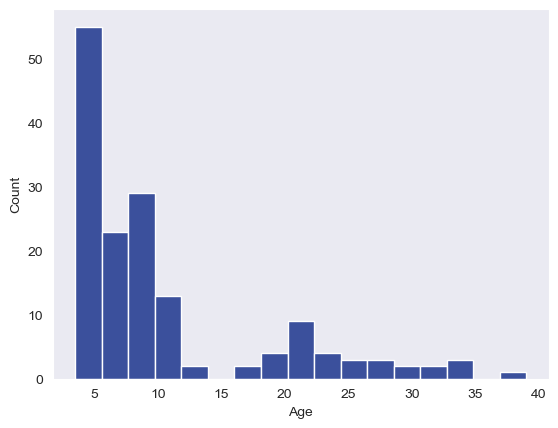

In [20]:
sns.set_style("dark")
sns.set_palette("dark")
sns.histplot(age)

#skewness and kurtosis
print("Asymmetry: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())



- **Skewness**: 
  - Skewness measures the asymmetry of the distribution of values in a dataset. 
  - A skewness of 0 indicates a symmetric distribution.


- **Kurtosis**:
  - Kurtosis measures the "tailedness" or the degree of outliers in the distribution of values.



**Load the atlas**

* The DiFuMo atlas provides dictionaries of functional modes optimized for extracting functional signals from fMRI data, available in various dimensionalities (64, 128, 256, 512, and 1024).

* Has multiple resolutions, for larger networks or finer-grained ROIs. 

Let's use a 64-ROI atlas to allow some detail, but to ultimately keep our connectivity matrices manageable


In [21]:
dim = 64
difumo = datasets.fetch_atlas_difumo(
    dimension=dim, resolution_mm=2, legacy_format=False
)

atlas_filename = difumo.maps




This code segment loads the DiFuMo atlas, which provides dictionaries of functional modes optimized for extracting functional signals from fMRI data.
1. **Specifying Atlas Dimensionality**:
 
   - This line sets the desired dimensionality of the atlas to 64. This means the atlas will contain 64 regions of interest (ROIs).

2. **Fetching the Atlas**:

   - This line fetches the DiFuMo atlas using the `fetch_atlas_difumo` function from the `datasets` module in the `nilearn` library.
   - Parameters:
     - `dimension=dim`: Specifies the desired dimensionality of the atlas.
     - `resolution_mm=2`: Sets the resolution of the atlas in millimeters. Here, it's set to 2 mm.
     - `legacy_format=False`: This parameter is set to `False`, indicating that the fetched atlas will use the non-legacy format.

3. **Accessing Atlas Filename**:

   - This line extracts the filename of the atlas maps from the fetched `difumo` object.

After executing this code, the variable `atlas_filename` will contain the filename of the DiFuMo atlas maps corresponding to the specified dimensionality (64 ROIs) and resolution. 

In [22]:
difumo.labels

component                       difumo_names     yeo_networks7  \
0           1            Superior frontal sulcus          DefaultB   
1           2                     Fusiform gyrus  No network found   
2           3         Calcarine cortex posterior           VisCent   
3           4         Cingulate cortex posterior          DefaultB   
4           5  Parieto-occipital sulcus superior             ContA   
..        ...                                ...               ...   
59         60                             Cuneus           VisCent   
60         61              Middle temporal gyrus          DefaultB   
61         62             Superior frontal gyrus          DefaultB   
62         63                     Central sulcus           SomMotA   
63         64                            Caudate  No network found   

      yeo_networks17        gm        wm       csf  
0           DefaultA  0.689996  0.185709  0.116884  
1   No network found  0.844733  0.021026  0.133789  
2            VisPeri  0.601768  0.302067  0.091297  
3           DefaultA  0.740086  0.140368  0.119567  
4              ContC  0.640157  0.241492  0.117826  
..               ...       ...       ...       ...  
59           VisPeri  0.627179  0.269783  0.103005  
60          DefaultB  0.726527  0.149595  0.107329  
61          DefaultB  0.651182  0.062243  0.224067  
62           SomMotB  0.578502  0.291674  0.109244  
63  No network found  0.703295  0.260386  0.036332  

[64 rows x 7 columns]

The provided data contains information about the labels of the regions in the DiFuMo atlas.

- **Columns**:
  - `component`: Represents the index or identifier of each region in the atlas.
  - `difumo_names`: Provides the name of the region according to the DiFuMo atlas.
  - `yeo_networks7`: Indicates the Yeo 7-network assignment for the region.
  - `yeo_networks17`: Indicates the Yeo 17-network assignment for the region.
  - `gm`: Represents the gray matter probability for the region.
  - `wm`: Represents the white matter probability for the region.
  - `csf`: Represents the cerebrospinal fluid probability for the region.

- **Rows**:
  - Each row corresponds to a specific region in the atlas, indexed by the `component` column.

- **Data**:
  - The data provides information about the anatomical and network assignments of each region, as well as probabilities of gray matter, white matter, and cerebrospinal fluid for each region.

This information is useful for understanding the anatomical and functional properties associated with each region in the DiFuMo atlas, which can be utilized in various neuroimaging analyses and interpretations.

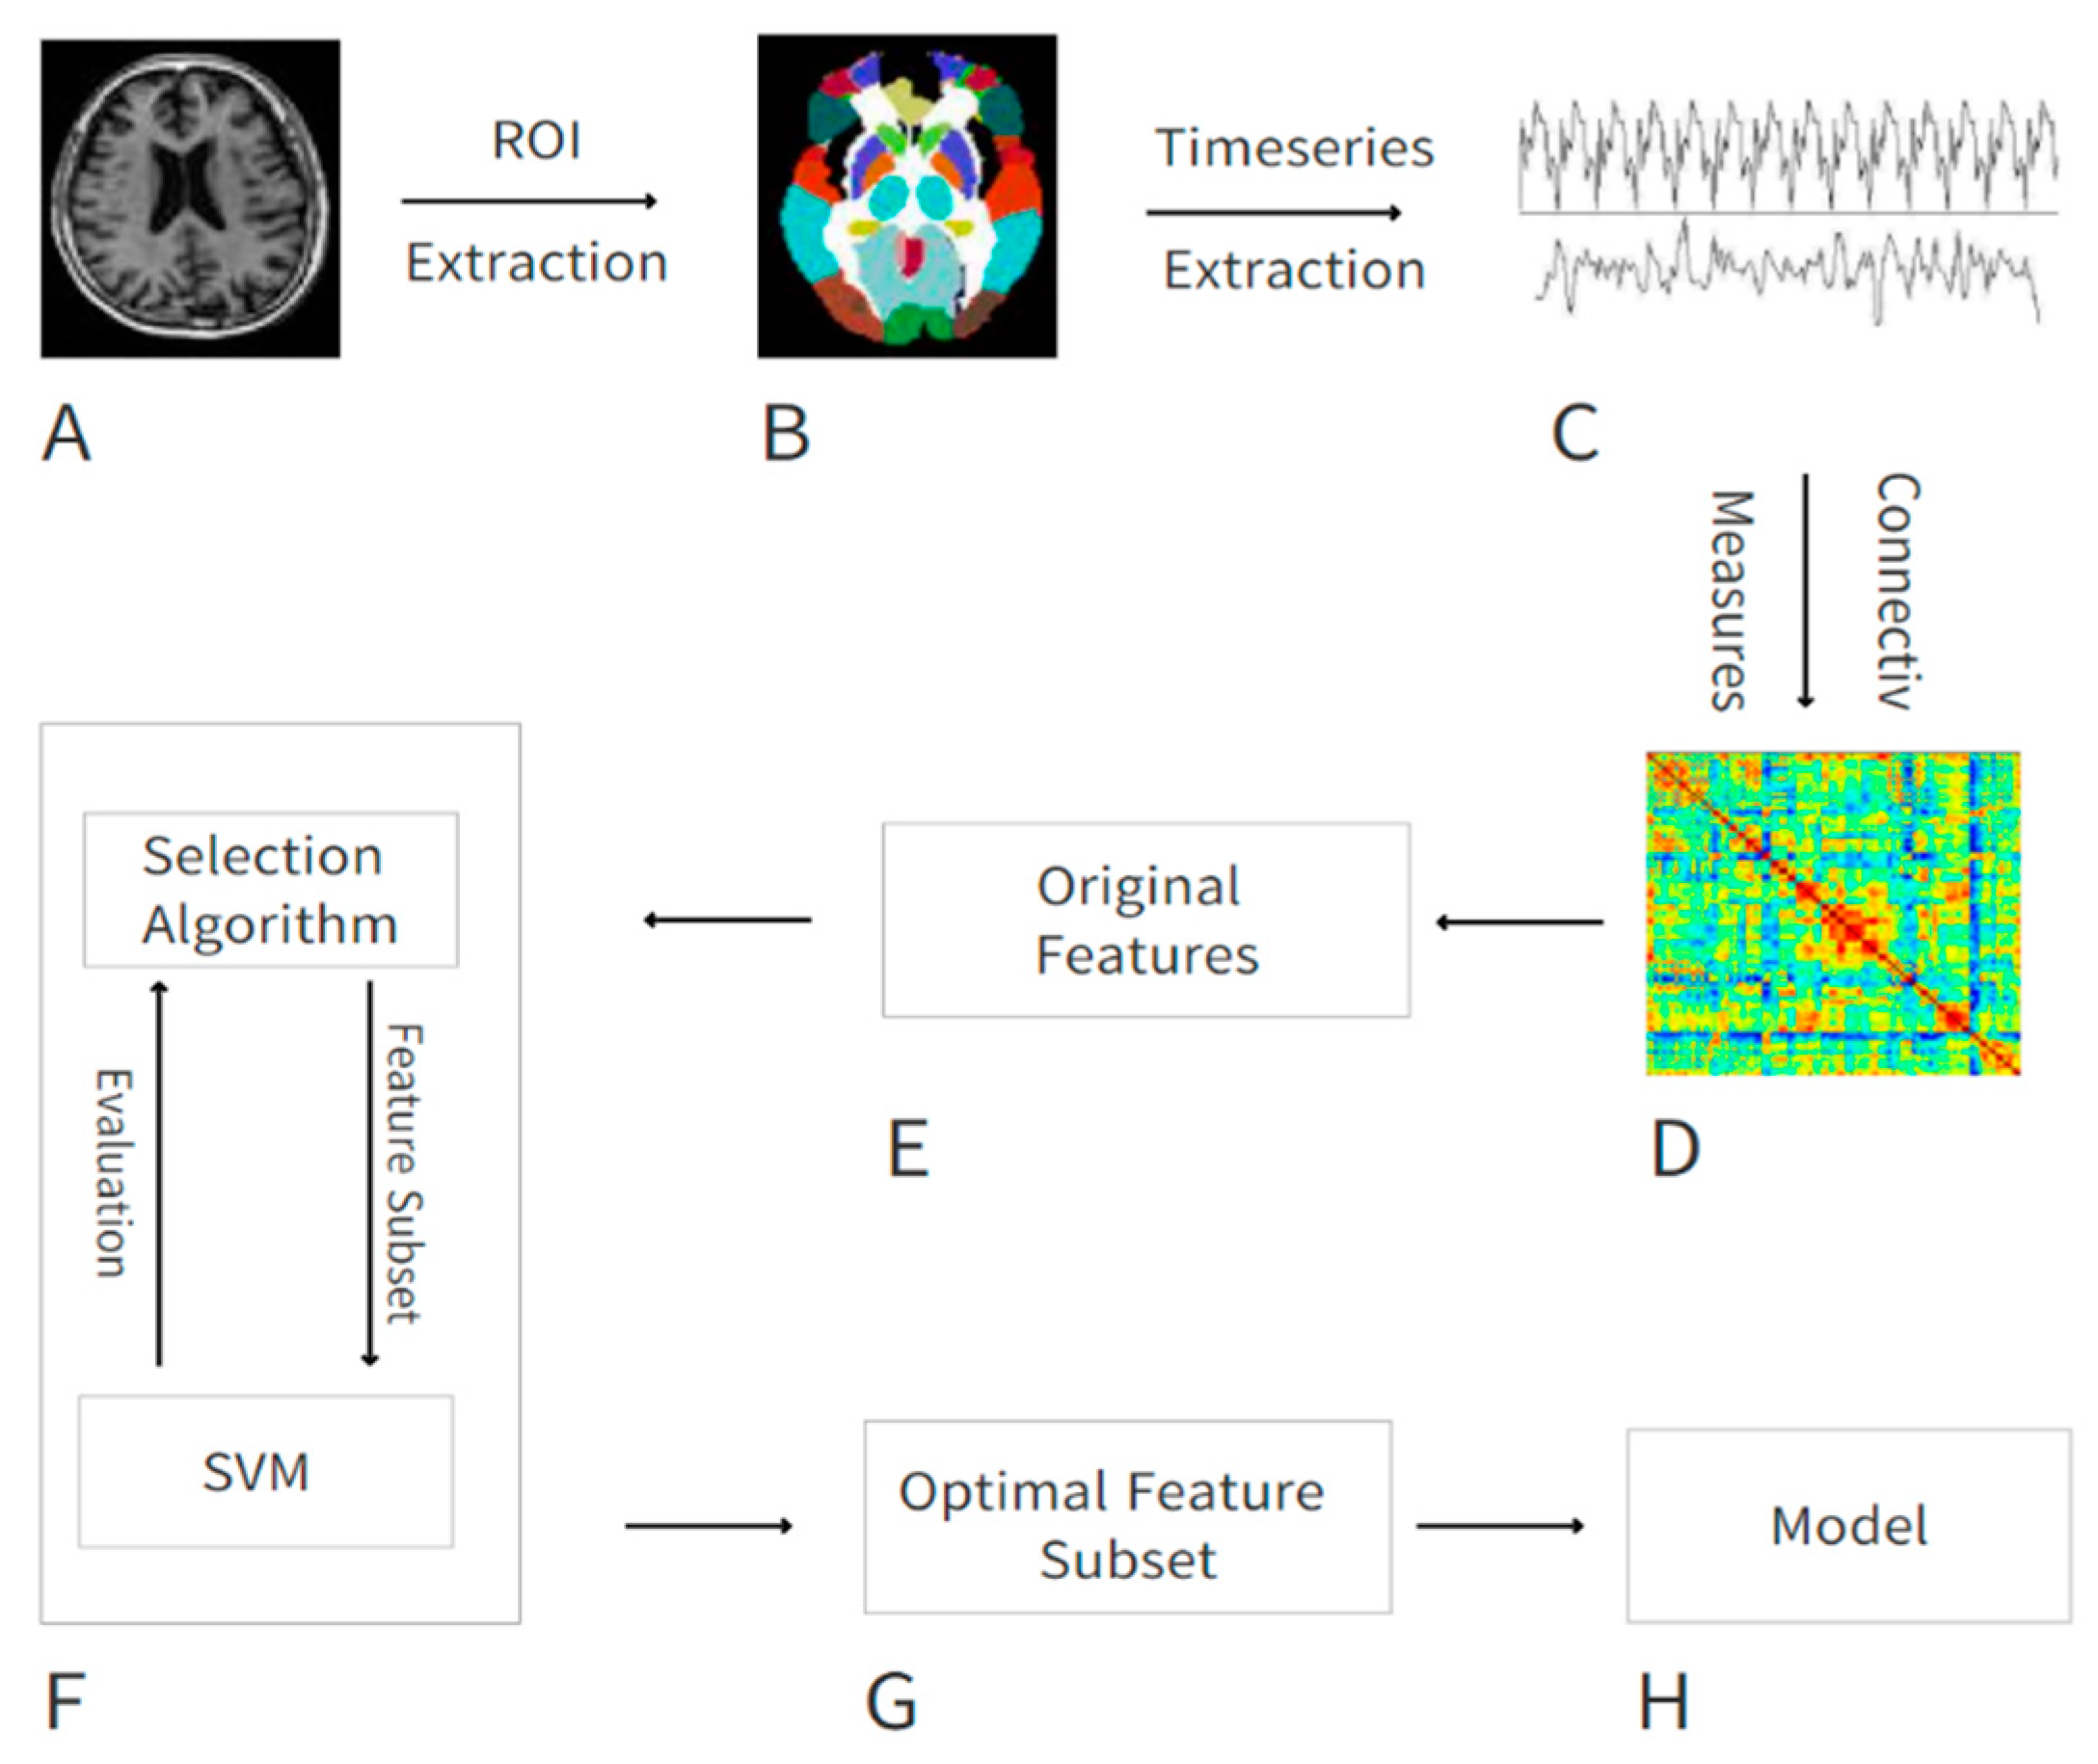

### Extract features with nilearn masker

Compute a correlation matrix, representing regional coactivation between regions and extract signals from a brain parcellation 


In [23]:
from nilearn.maskers import MultiNiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

# create masker using MultiNiftiMapsMasker to extract functional data within
# atlas parcels from multiple subjects using parallelization to speed up the
# # computation
masker = MultiNiftiMapsMasker(
    maps_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    n_jobs=2, verbose=0
)

# ConenctivityMeasure from Nilearn uses simple 'correlation' to compute
# connectivity matrices for all subjects in a list
connectome_measure = ConnectivityMeasure(
    kind="correlation", vectorize=True, discard_diagonal=True)




**Extract fMRI connectivity features from every subject.**



In [24]:
all_features = [
    connectome_measure.fit_transform([masker.fit_transform(sub, confounds=data.confounds[i])])[0]
    for i, sub in enumerate(data.func)
]


In [25]:
# Let's save the data to disk

np.savez_compressed('Age_Difumo_featuress.npz',a = all_features)

In [26]:
# Load the features

feat_file = 'Age_Difumo_featuress.npz'
X_features = np.load(feat_file)['a']

print('Features shape:', X_features.shape)

Features shape: (155, 2016)



 **Number of Features**:
   - Each subject has a set of features associated with it.
   - In this case, each subject's features consist of a correlation matrix.
   - The correlation matrix represents the strength of connections between different brain regions.
   - Since each correlation matrix has been vectorized (flattened into a one-dimensional array) using the `vectorize=True` parameter when computing connectivity measures, each matrix is represented by 2016 features.
   - This number is derived from the fact that a symmetric matrix with 64 rows/columns (as in the case of the 64-ROI atlas used) would have \( \frac{{64 \times (64 + 1)}}{2} = 2016 \) unique elements after being vectorized, as it includes the diagonal elements.

So, each of the 2016 features corresponds to a specific connection between two brain regions in the correlation matrix. Each subject's set of features contains information about how strongly these connections are correlated.

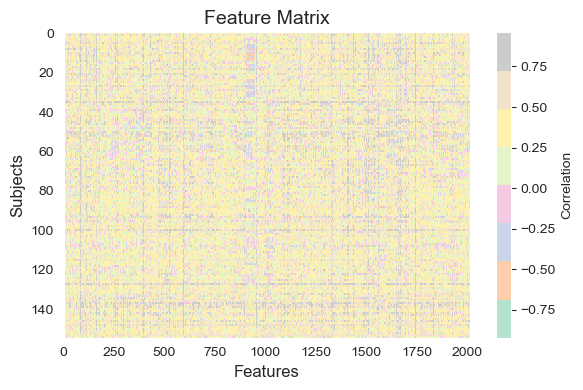

In [27]:
# Create the plot
plt.figure(figsize=(6, 4))
plt.imshow(X_features, aspect='auto', cmap='Pastel2', interpolation='nearest')

# Add colorbar
plt.colorbar(label='Correlation')

# Add title and labels
plt.title('Feature Matrix', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Subjects', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


## Prepare data for machine learning

In [29]:
y_age = pheno['Age']

print('y type:',type(y_age))
print('X type:',type(X_features))

y type: <class 'pandas.core.series.Series'>
X type: <class 'numpy.ndarray'>


In [31]:
from sklearn.model_selection import train_test_split

# Split the sample into training/test
X_train, X_test, y_train, y_test = train_test_split(
    X_features,  # Features
    y_age,  # Target variable
    test_size=0.3,  # 70%/30% split
    shuffle=True,  # Shuffle dataset before splitting
    random_state=123  # Set random state for reproducibility
)

# Print the size of the training and test sets
print('Training set size:', len(X_train))
print('Testing set size:', len(X_test))


Training set size: 108
Testing set size: 47


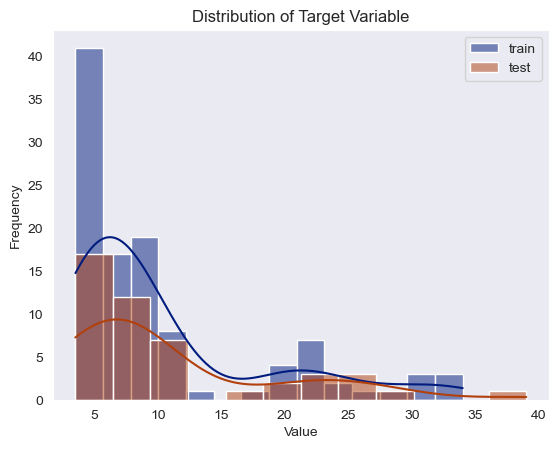

training: 108 testing: 47


In [32]:
# Check data distribution
sns.histplot(y_train, label='train', kde=True)
sns.histplot(y_test, label='test', kde=True)
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.show()

# Print the size of the training and test sets
print('training:', len(X_train), 'testing:', len(X_test))


## Run our model!

We'll start with a standard classification model called a Support Vector Classifier (SVC)

Despite its simplicity, this model shines in its ability to deliver robust results. Given our data constraints, a straightforward approach often proves to be the most effective.

In [41]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split

# Create an instance of the Support Vector Regressor
svr_model = SVR()  

# Define hyperparameters to tune
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear'],  # Kernel types: linear and radial basis function
    'gamma': ['scale', 'auto', 0.1, 1, 10]  # Kernel coefficient for 'rbf' kernel
}

# Define cross-validation technique (Stratified K-Fold is not used for regression)
cv = 5  # Number of folds for cross-validation

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=cv)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters:", best_params)


Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


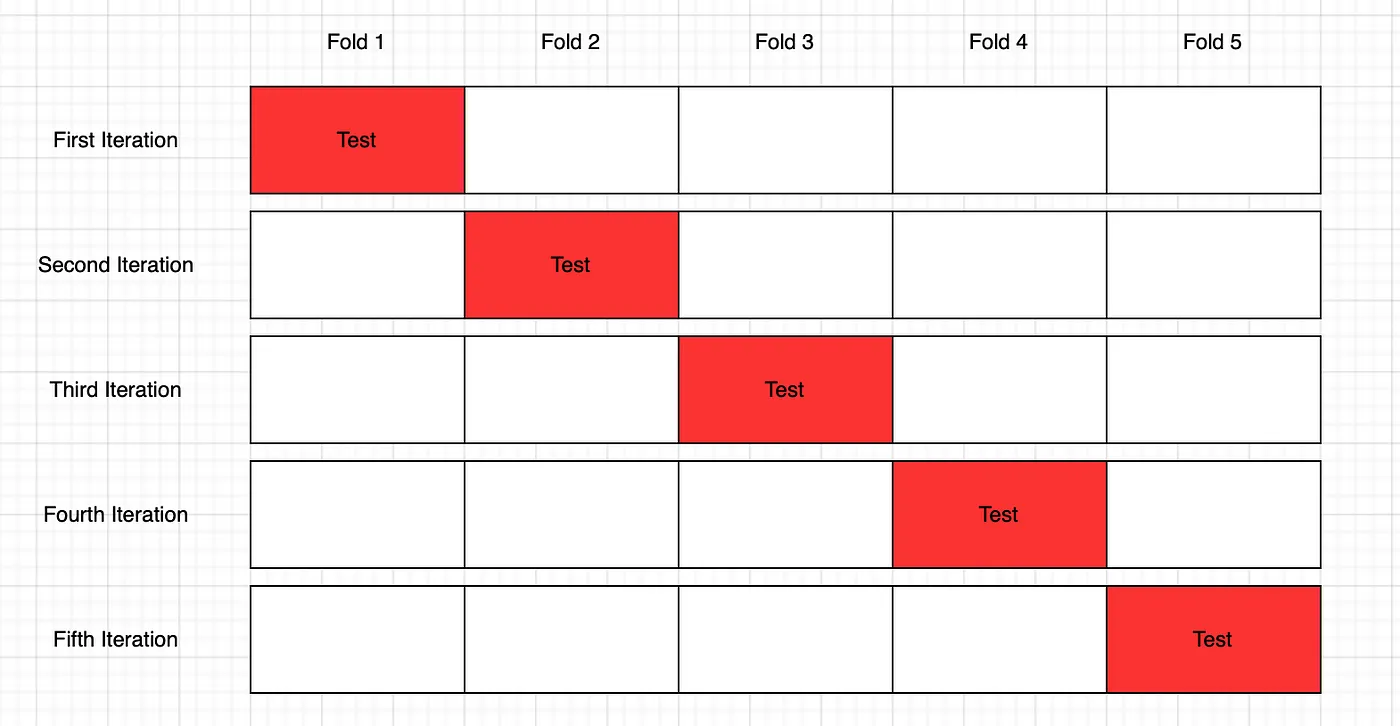

In [42]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error, r2_score

# Train the model with the best parameters
best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_svr_model.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

# Calculate mean squared error (MSE) as well
mse = mean_squared_error(y_test, y_pred)

# Print results

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r_squared)


Mean Squared Error (MSE): 19.708237147225983
R-squared (R2): 0.7163758169890162


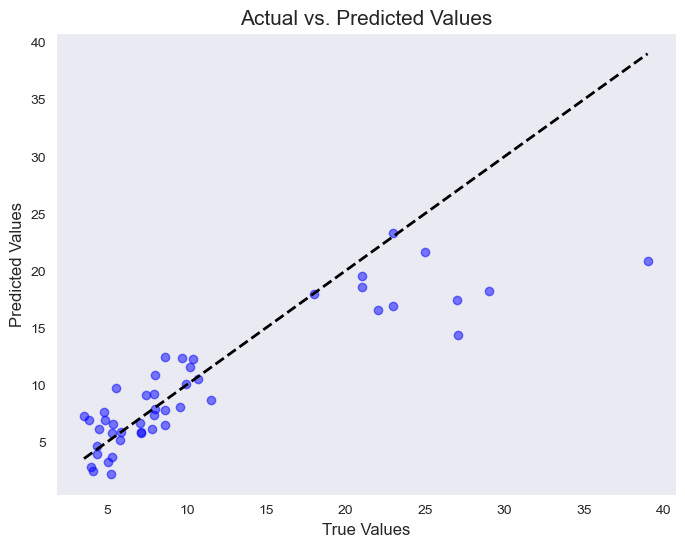

In [43]:
# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("True Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.title("Actual vs. Predicted Values", fontsize=15)
plt.show()


## Interpreting model feature importance

In [45]:
correlation_measure = connectome_measure

connectome_measure.inverse_transform(best_svr_model.coef_).shape

(1, 64, 64)

In [46]:
# Extract support vectors and their coefficients
support_vectors = best_svr_model.support_vectors_
dual_coef = best_svr_model.dual_coef_

# Calculate the importance of features using the support vectors and dual coefficients
feature_importance = np.dot(dual_coef, support_vectors)

# Inverse transform to the original feature space if needed
inverse_transformed_feature_importance = connectome_measure.inverse_transform(feature_importance)

# Shape of the inverse transformed feature importance
shape = inverse_transformed_feature_importance.shape


In [ ]:
# Get the coefficients (weights) of the linear SVM model from best_estimator
coefficients = best_svr_model.coef_



plt.bar(range(coefficients.shape[-1]),coefficients[0])
plt.gca().set_facecolor('viridis')  # Change background color
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')


1. **Interpreting Model Feature Importance**:
   - This line of code aims to interpret the feature importance of the SVM model.
   - `correlation_measure.inverse_transform(best_svr_model.coef_)` is a function call that helps transform the coefficients of the SVM model back to the original space of the features.
   - The result of this transformation is stored in the variable `feat_exp_matrix`.

2. **Understanding the Result**:
   - `feat_exp_matrix` represents the feature importance matrix obtained from the SVM model.
   - Each element in `feat_exp_matrix` corresponds to the importance or weight assigned to a specific feature (in this case, the correlation between different brain regions).
   - The shape of `feat_exp_matrix` is `(64, 64)`, indicating that it is a square matrix where each row and column correspond to one of the 64 brain regions.


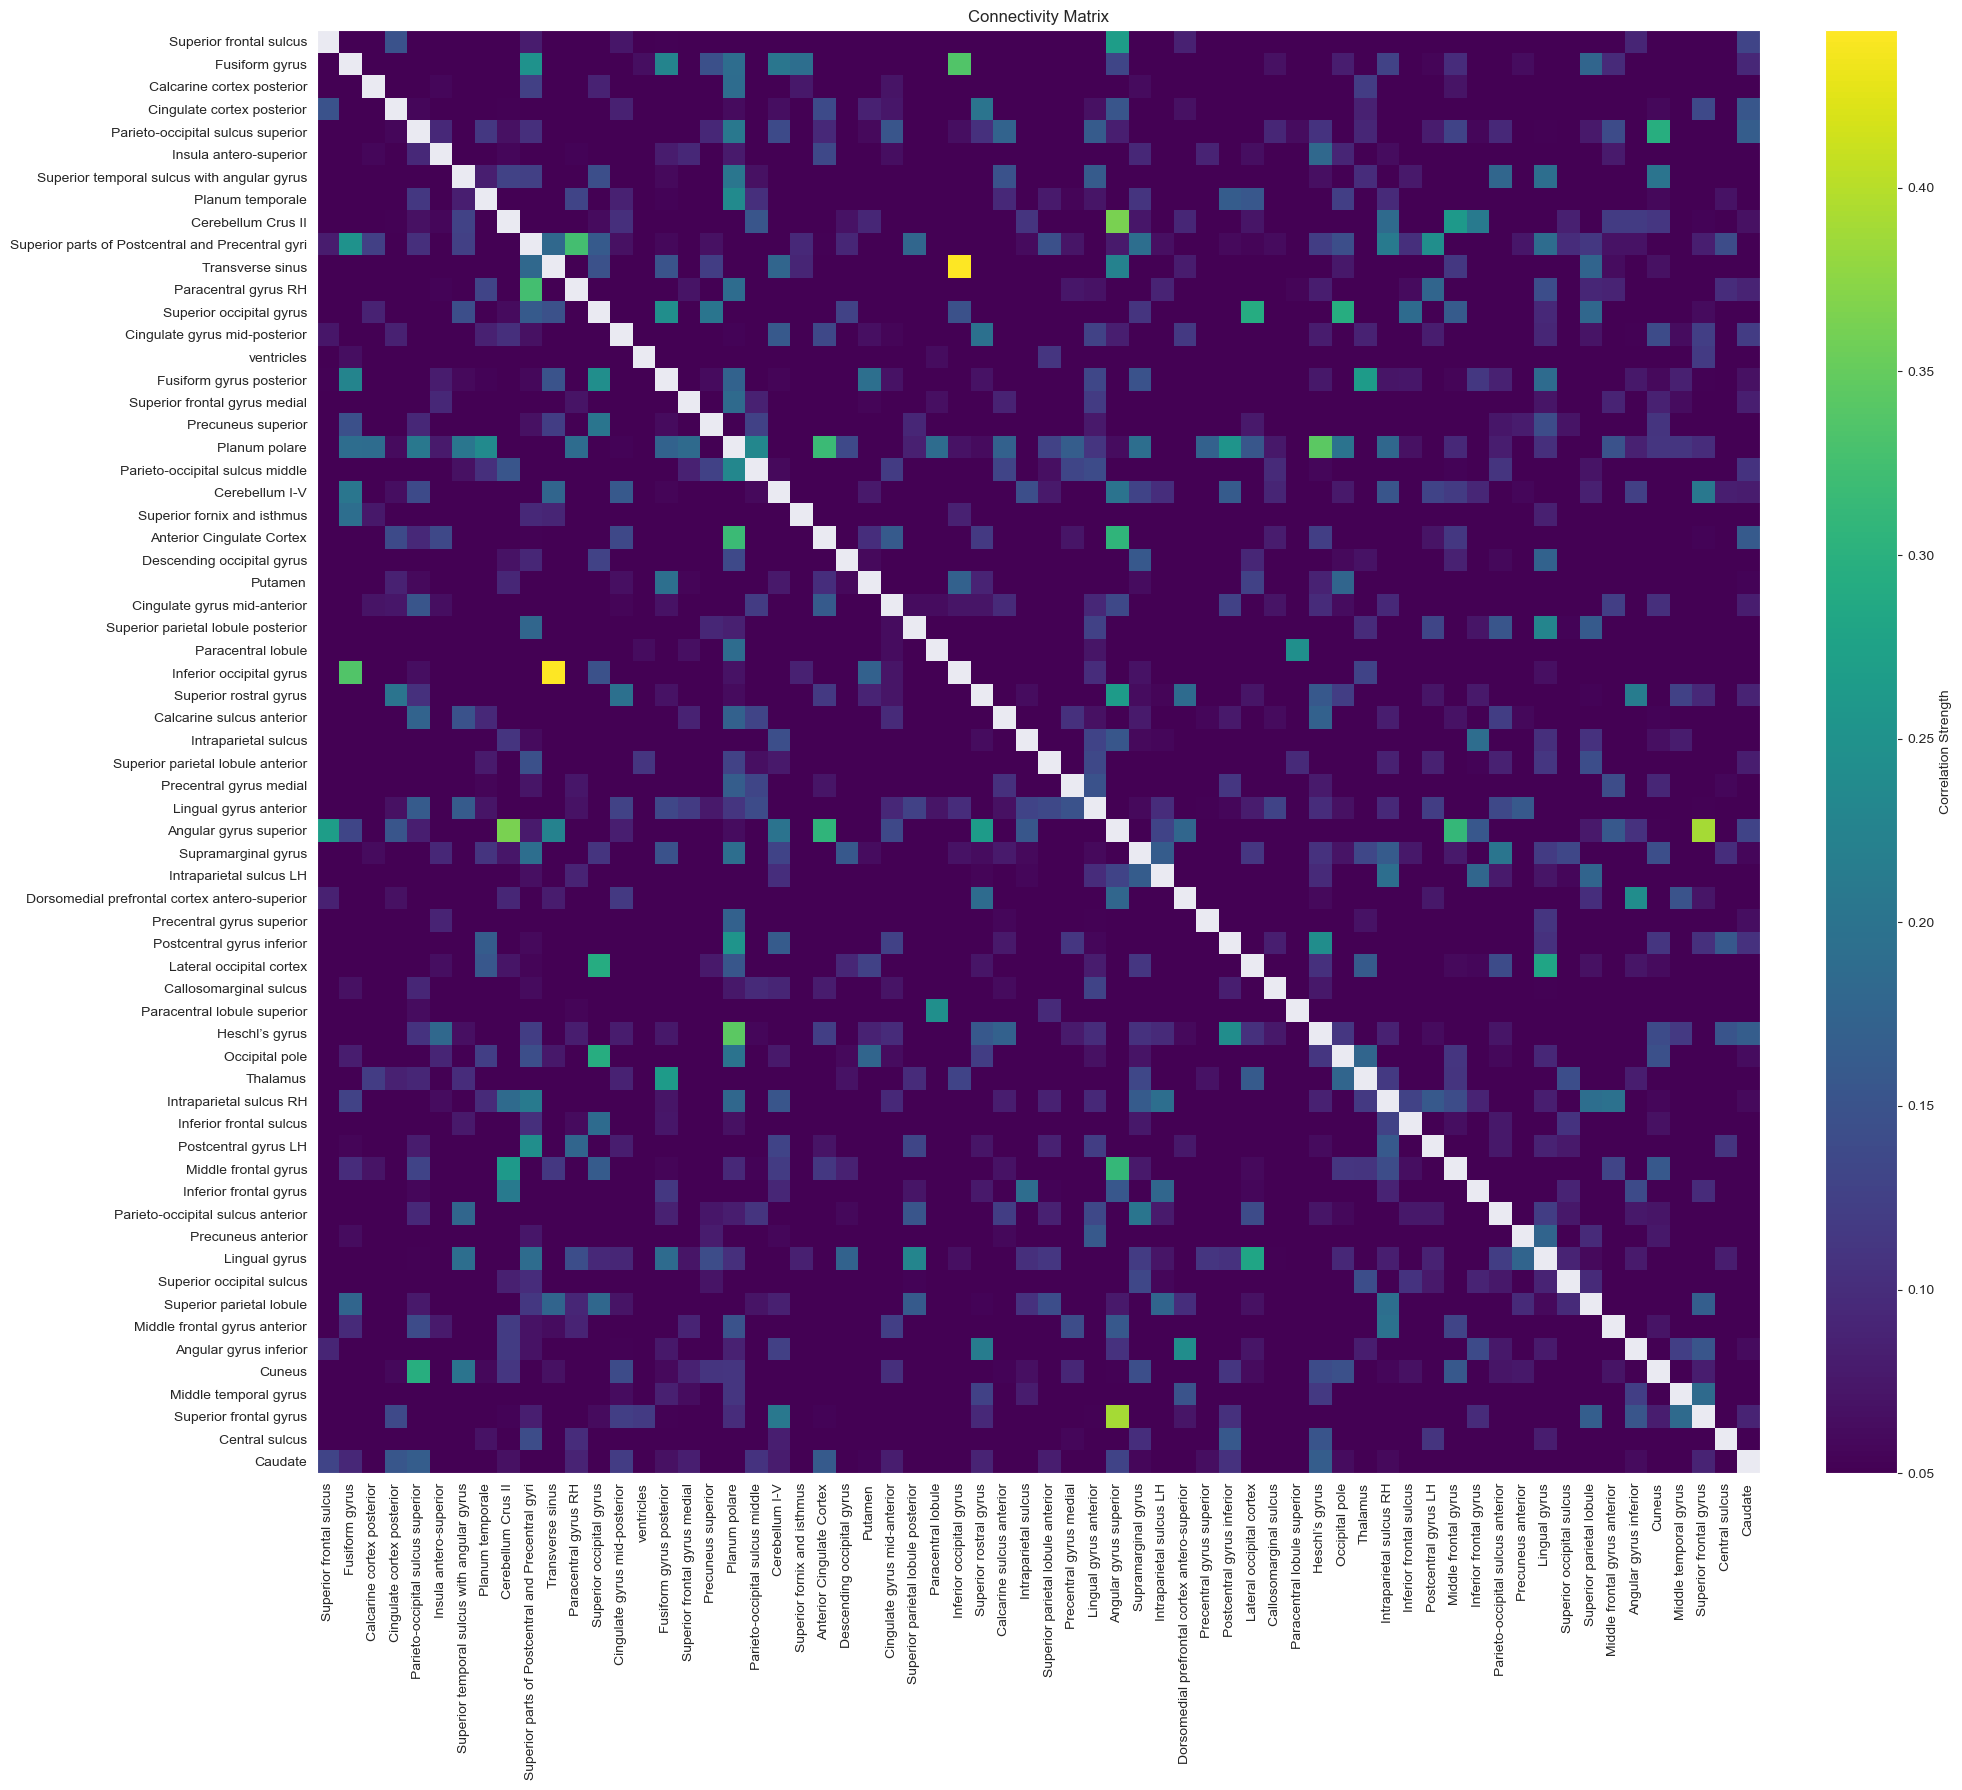

In [50]:
feat_exp_matrix = correlation_measure.inverse_transform(best_svr_model.coef_)[0]

# Define a threshold to visualize only higher values
threshold = 0.05  # Adjust this threshold as needed

labels = difumo.labels["difumo_names"]

# Replace diagonal with NaN to remove it from the plot
np.fill_diagonal(feat_exp_matrix, np.nan)

# Plot the matrix
plt.figure(figsize=(20, 18))  # Adjust the figure size as needed
plt.imshow(feat_exp_matrix, cmap='viridis', origin='upper', vmin=threshold)
plt.colorbar(label='Correlation Strength', fraction=0.046, pad=0.04)  # Adjust color bar position

# Add labels to the ticks
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.yticks(ticks=range(len(labels)), labels=labels)

# Add title
plt.title('Connectivity Matrix')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

This code iterates over the correlation matrix and prints the correlation values between different brain regions that exceed the specified threshold.

1. **Iteration Over the Matrix**:
   - The code uses nested loops to iterate over each element of the correlation matrix.
   - The outer loop (`for i in range(len(labels))`) iterates over the rows of the matrix, representing one brain region.
   - The inner loop (`for j in range(len(labels))`) iterates over the columns of the matrix, representing another brain region.

2. **Condition for Printing**:
   - Within the nested loops, the code checks if the current element is not on the diagonal (i.e., `i != j`) to avoid printing self-correlations.
   - It also checks if the correlation value (`feat_exp_matrix[i, j]`) is greater than or equal to the specified threshold.

3. **Printing Correlation Values**:
   - If both conditions are met, the code prints the names of the two brain regions (`labels[i]` and `labels[j]`) along with their correlation value.


In [58]:
# Define a threshold to visualize only higher values
threshold = 0.3  # Adjust this threshold as needed

# Iterate over the correlation matrix and print the values
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and feat_exp_matrix[i, j] >= threshold:
            print(f"{labels[i]} - {labels[j]}: {feat_exp_matrix[i, j]}")


Fusiform gyrus - Inferior occipital gyrus: 0.33580747256933074
Cerebellum Crus II - Angular gyrus superior: 0.3645928984699938
Superior parts of Postcentral and Precentral gyri - Paracentral gyrus RH: 0.3254989169606637
Transverse sinus - Inferior occipital gyrus: 0.44287579844026276
Paracentral gyrus RH - Superior parts of Postcentral and Precentral gyri: 0.3254989169606637
Planum polare - Anterior Cingulate Cortex: 0.3177710145141055
Planum polare - Heschl’s gyrus: 0.3442496787060604
Anterior Cingulate Cortex - Planum polare: 0.3177710145141055
Anterior Cingulate Cortex - Angular gyrus superior: 0.3072873468650626
Inferior occipital gyrus - Fusiform gyrus: 0.33580747256933074
Inferior occipital gyrus - Transverse sinus: 0.44287579844026276
Angular gyrus superior - Cerebellum Crus II: 0.3645928984699938
Angular gyrus superior - Anterior Cingulate Cortex: 0.3072873468650626
Angular gyrus superior - Middle frontal gyrus: 0.3110698564012516
Angular gyrus superior - Superior frontal gyrus

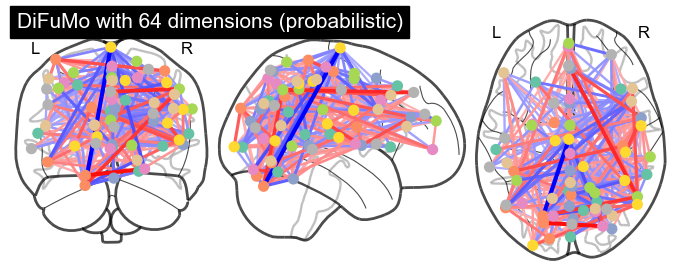

In [52]:

# grab center coordinates for probabilistic atlas
coordinates = plotting.find_probabilistic_atlas_cut_coords(
    maps_img=difumo.maps
)

# plot connectome with 95% edge strength in the connectivity
plotting.plot_connectome(
    feat_exp_matrix,
    coordinates,
    edge_threshold="95%",
    title=f"DiFuMo with {dim} dimensions (probabilistic)",
)
plotting.show()



1. **Grabbing Center Coordinates for Probabilistic Atlas**:
   - `coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=difumo.maps)`: This line of code uses the `find_probabilistic_atlas_cut_coords()` function from the `plotting` module in Nilearn to extract the center coordinates for the probabilistic atlas.
   - The `maps_img=difumo.maps` argument specifies the probabilistic atlas image from which the coordinates will be extracted.

2. **Plotting the Connectome**:
   - `plotting.plot_connectome()`: This function is used to visualize connectivity networks (connectomes) using brain surface plots or scatter plots.
   - Arguments:
     - `feat_exp_matrix`: The feature importance matrix or the connectivity matrix to be visualized.
     - `coordinates`: The coordinates of brain regions, typically obtained from the atlas used to parcellate the brain.
     - `edge_threshold="85%"`: Specifies the threshold for displaying edges (connections) in the connectome. Here, "85%" means that only edges with strengths in the top 85% will be displayed.
     - `title=f"DiFuMo with {dim} dimensions (probabilistic)"`: The title of the plot. It dynamically includes the dimensionality (`dim`) of the DiFuMo atlas used and specifies that it's a probabilistic atlas.
   
3. **Displaying the Plot**:
   - `plotting.show()`: This function displays the plot generated by the `plot_connectome()` function.

It highlights strong connections between brain regions while excluding weaker connections based on the specified threshold. The resulting plot provides insights into the organization of brain networks derived from the connectivity data.

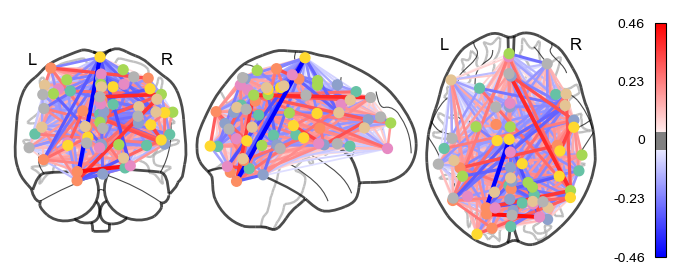

In [53]:
# Create a connectome map where each node is an ROI

coords = plotting.find_probabilistic_atlas_cut_coords(
    maps_img=difumo.maps
)

plotting.plot_connectome(feat_exp_matrix, coords, colorbar=True, edge_threshold=0.8)

In [59]:
plotting.view_connectome(feat_exp_matrix, coords, edge_threshold=0.4,
                        edge_cmap='viridis')

In [60]:
threshold = 0.4  # Adjust this threshold as needed

# Iterate over the correlation matrix and print the values
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and feat_exp_matrix[i, j] >= threshold:
            print(f"{labels[i]} - {labels[j]}: {feat_exp_matrix[i, j]}")


Transverse sinus - Inferior occipital gyrus: 0.44287579844026276
Inferior occipital gyrus - Transverse sinus: 0.44287579844026276


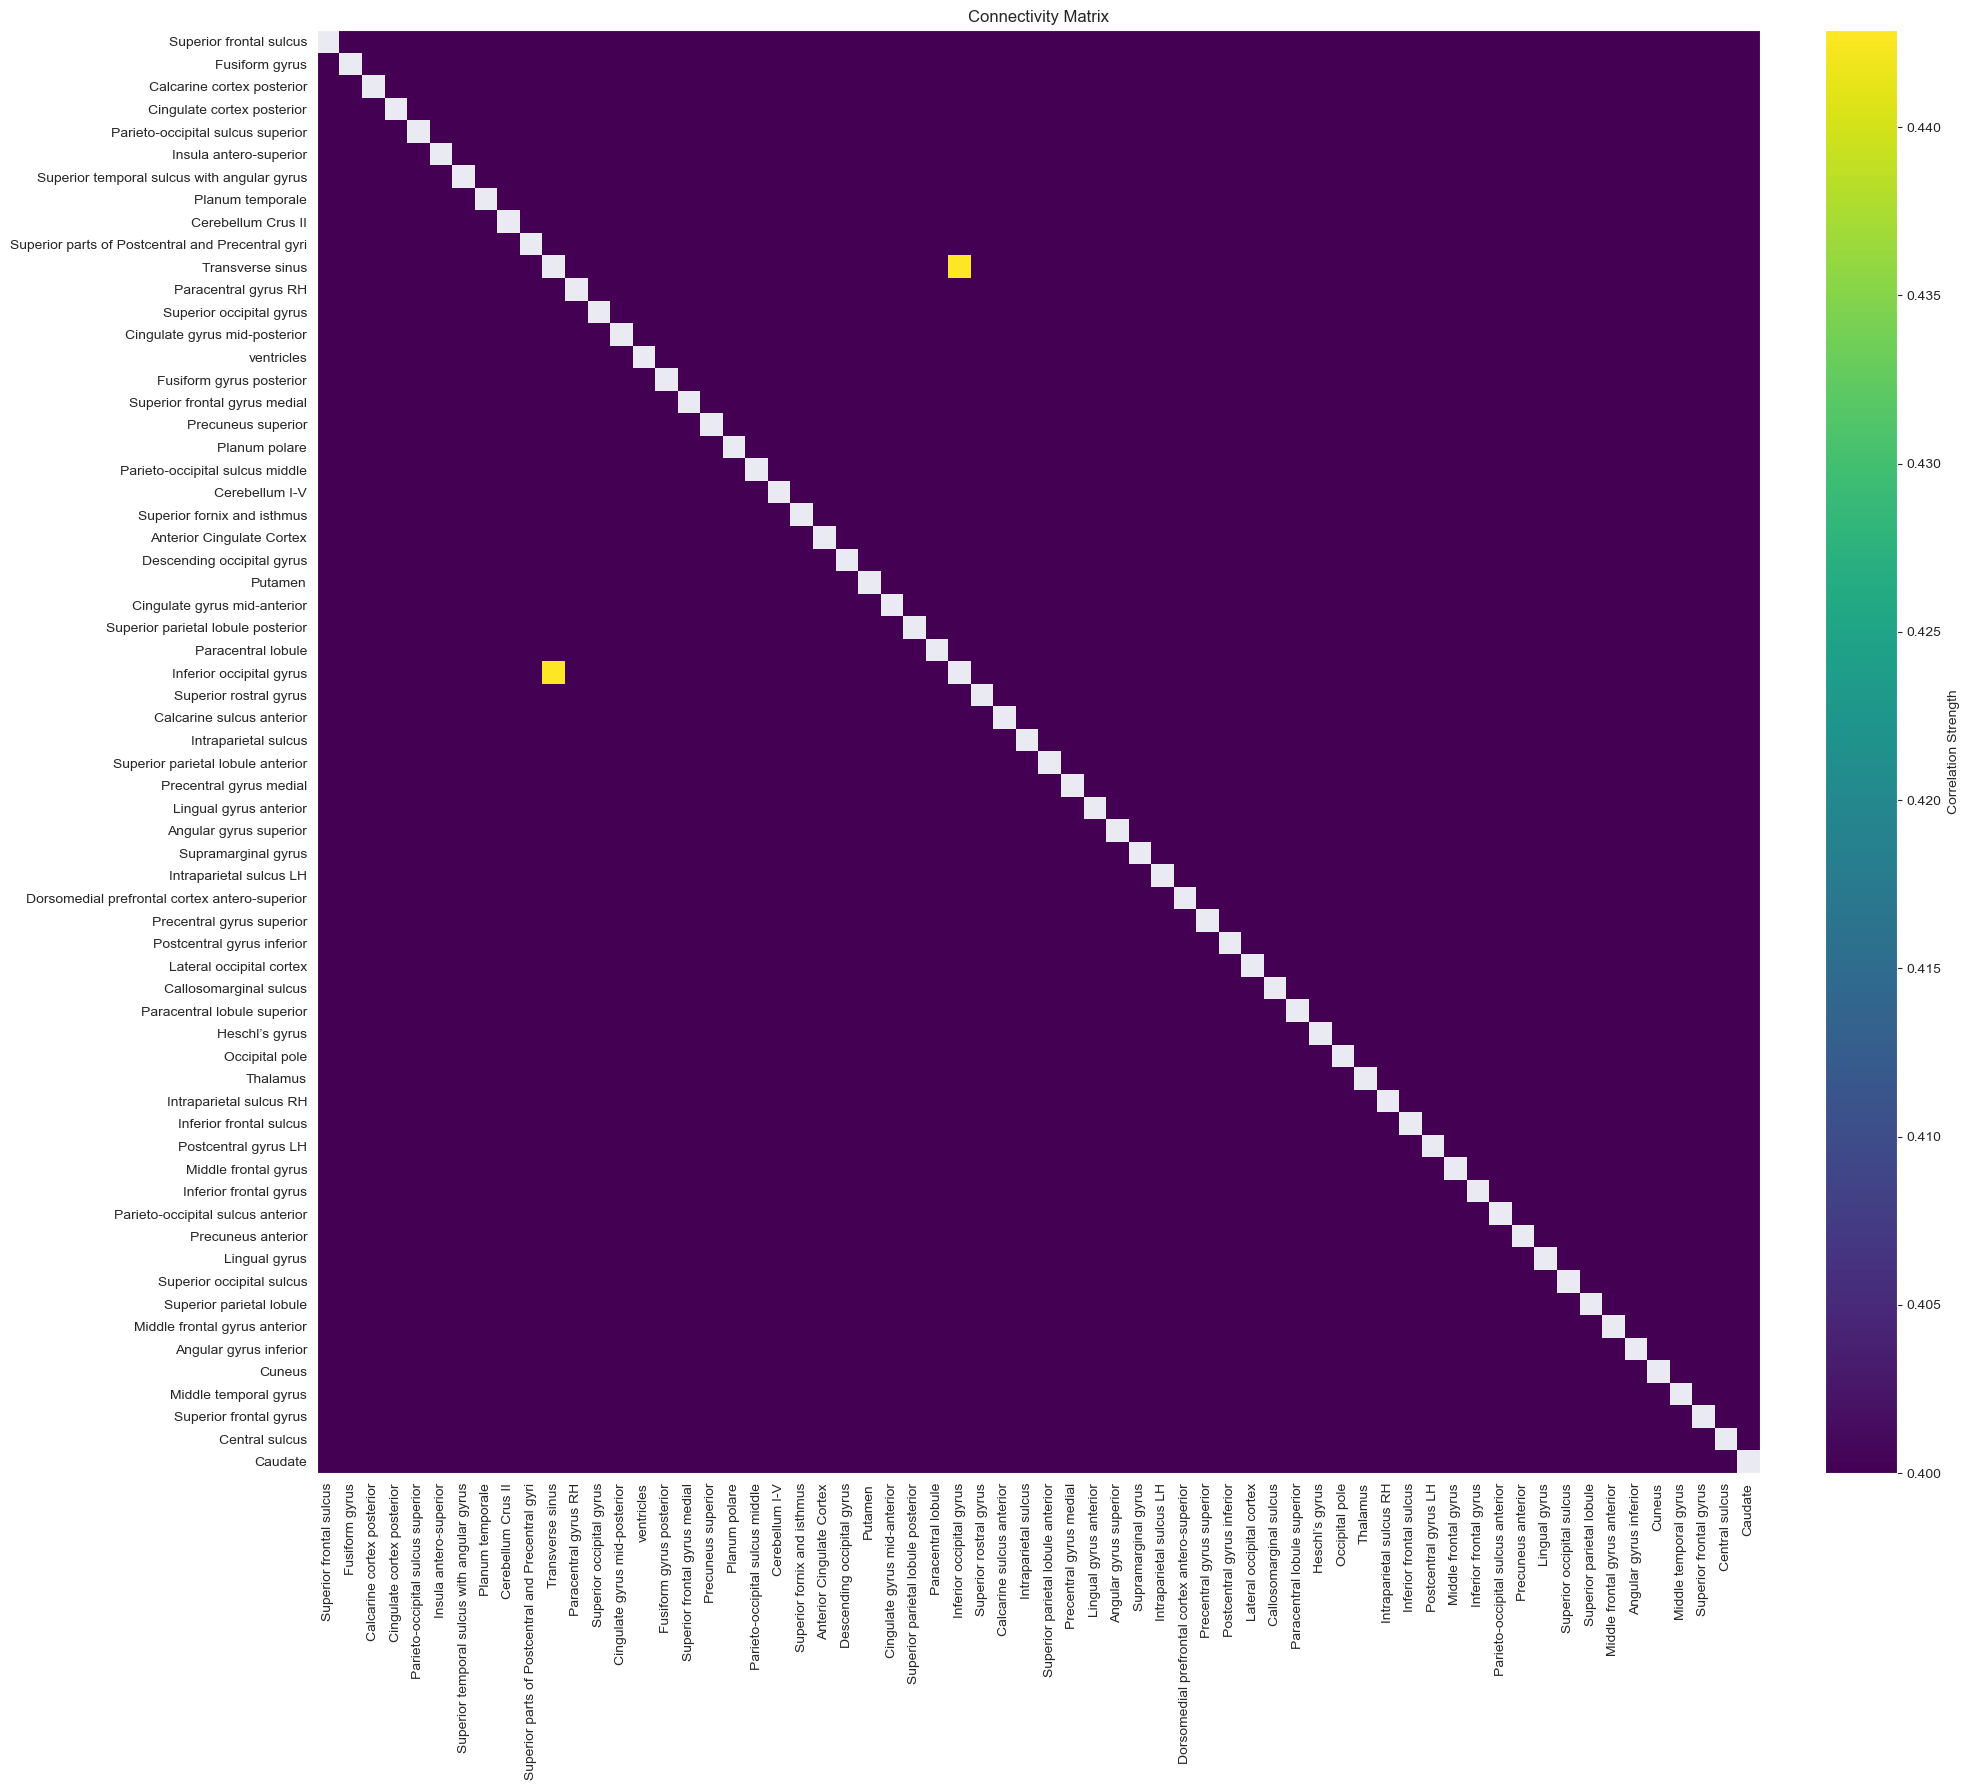

In [61]:


# Define a threshold to visualize only higher values
threshold = 0.4  # Adjust this threshold as needed

# Plot the matrix
plt.figure(figsize=(20, 18))  # Adjust the figure size as needed
plt.imshow(feat_exp_matrix, cmap='viridis', origin='upper', vmin=threshold)
plt.colorbar(label='Correlation Strength', fraction=0.046, pad=0.04)  # Adjust color bar position

# Add labels to the ticks
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.yticks(ticks=range(len(labels)), labels=labels)

# Add title
plt.title('Connectivity Matrix')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
